<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-the-Data" data-toc-modified-id="Importing-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing the Data</a></span><ul class="toc-item"><li><span><a href="#Metadata-File" data-toc-modified-id="Metadata-File-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>Metadata</code> File</a></span></li><li><span><a href="#train_labels-File" data-toc-modified-id="train_labels-File-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><code>train_labels</code> File</a></span></li><li><span><a href="#Prepping-the-data-for-the-Satellite-imagery-analysis." data-toc-modified-id="Prepping-the-data-for-the-Satellite-imagery-analysis.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prepping the data for the Satellite imagery analysis.</a></span></li><li><span><a href="#Setting-up-the-DataFrame" data-toc-modified-id="Setting-up-the-DataFrame-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Setting up the DataFrame</a></span></li></ul></li><li><span><a href="#Temperature-Data" data-toc-modified-id="Temperature-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Temperature Data</a></span><ul class="toc-item"><li><span><a href="#different-approach-from-chatgpt" data-toc-modified-id="different-approach-from-chatgpt-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>different approach from chatgpt</a></span></li><li><span><a href="#This-is-now-from-chat-gpt" data-toc-modified-id="This-is-now-from-chat-gpt-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>This is now from chat gpt</a></span></li></ul></li><li><span><a href="#This-is-me-doing-crazy-stuff" data-toc-modified-id="This-is-me-doing-crazy-stuff-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>This is me doing crazy stuff</a></span><ul class="toc-item"><li><span><a href="#Trying-from-aws" data-toc-modified-id="Trying-from-aws-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Trying from aws</a></span></li></ul></li></ul></div>

Running main notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import geopy.distance as distance

import planetary_computer as pc
from pystac_client import Client

from datetime import datetime, date
from datetime import timedelta

# from keras.utils import load_img, img_to_array
import requests
from PIL import Image
from io import BytesIO

from tqdm import tqdm
tqdm.pandas()

import rioxarray
import cv2
import odc.stac
import tempfile
import rasterio
import os

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import functions
import functions2

import warnings
warnings.filterwarnings('ignore')

import cfgrib
import boto3
import netCDF4
import pygrib

# Importing the Data

## `Metadata` File

In [2]:
# Reading in the data and bringing in date as datetime dtype
metadata = pd.read_csv('Data/metadata.csv', parse_dates=['date'])

## `train_labels` File

In [3]:
train_labels = pd.read_csv('Data/train_labels.csv')

## Prepping the data for the Satellite imagery analysis.

In [4]:
sat_df = metadata

In [5]:
sat_df

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train
...,...,...,...,...,...
23565,zzvv,36.708500,-121.749000,2014-12-02,test
23566,zzwo,39.792190,-99.971050,2017-06-19,train
23567,zzwq,35.794000,-79.012551,2015-03-24,train
23568,zzyb,35.742000,-79.238600,2016-11-21,train


In [6]:
sat_df['split'].value_counts()

train    17060
test      6510
Name: split, dtype: int64

In [7]:
sat_train = sat_df[sat_df['split'] == 'train'].copy()
sat_test = sat_df[sat_df['split'] == 'test'].copy()

Bringing back in the labels for sat_train.

In [8]:
sat_train = sat_train.merge(train_labels, on='uid')

## Setting up the DataFrame

Here I use a custom function to add a date range that the satellites can interpret and also include bounding boxes to later manipulate the images.

In [9]:
functions.get_important_info(sat_train, dist=31, big_crop_dist=3000, small_crop_dist=500, tiny_crop_dist=100);

In [10]:
sat_train.head(3)

,uid,latitude,longitude,date,split,region,severity,density,date_range,bbox,big_crop_bbox,small_crop_bbox,tiny_crop_bbox
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest,1,585.0,2018-04-29/2018-05-14,"[-87.00742888244132, 38.63091417147125, -85.85...","[-86.46553737052635, 39.05329612116674, -86.39...","[-86.43664511758249, 39.07581525298953, -86.42...","[-86.43202235685135, 39.079418305988106, -86.4..."
1,aacd,35.875083,-78.878434,2020-11-19,train,south,1,290.0,2020-11-04/2020-11-19,"[-79.43088170919651, 35.425434522510464, -78.3...","[-78.91165478658658, 35.84804560208817, -78.84...","[-78.88397103218583, 35.8705769758293, -78.872...","[-78.87954163128398, 35.87418198776951, -78.87..."
2,aaee,35.487000,-79.062133,2016-08-24,train,south,1,1614.0,2016-08-09/2016-08-24,"[-79.61191193921022, 35.03732231399556, -78.51...","[-79.09519299105324, 35.459960615407574, -79.0...","[-79.06764296370947, 35.48249344433146, -79.05...","[-79.06323495914324, 35.48609868913609, -79.06..."


In [11]:
functions.get_important_info(sat_test, dist=31, big_crop_dist=3000, small_crop_dist=500, tiny_crop_dist=100);

In [12]:
sat_test.head(3)

,uid,latitude,longitude,date,split,date_range,bbox,big_crop_bbox,small_crop_bbox,tiny_crop_bbox
1,aabn,36.559700,-121.51000,2016-08-31,test,2016-08-16/2016-08-31,"[-122.06728147535146, 36.11010270440991, -120....","[-121.5435112111439, 36.532665461053185, -121....","[-121.515585202077, 36.55519425204005, -121.50...","[-121.51111704041661, 36.558798850681036, -121..."
12,aair,33.042600,-117.07600,2014-11-01,test,2014-10-17/2014-11-01,"[-117.61009863726893, 32.59274323647839, -116....","[-117.10811706657985, 33.01554981570179, -117....","[-117.08135284459203, 33.038091644106125, -117...","[-117.07707056891928, 33.04169832908225, -117...."
14,aajw,40.703968,-80.29305,2015-08-26,test,2015-08-11/2015-08-26,"[-80.88337803767597, 40.25468908822623, -79.70...","[-80.32854854873526, 40.67695263815303, -80.25...","[-80.29896642510222, 40.69946544849961, -80.28...","[-80.29423328502216, 40.70306748998178, -80.29..."


# Temperature Data

In [13]:
sample_row = sat_train[sat_train['uid'] == 'garm']

In [14]:
sample_row

,uid,latitude,longitude,date,split,region,severity,density,date_range,bbox,big_crop_bbox,small_crop_bbox,tiny_crop_bbox
3950,garm,41.98006,-110.65734,2021-09-27,train,west,5,12267752.74,2021-09-12/2021-09-27,"[-111.25930520389633, 41.5308809188309, -110.0...","[-110.69353838433213, 41.953050646872555, -110...","[-110.6633730644045, 41.97555845000092, -110.6...","[-110.65854661288282, 41.97915969028358, -110...."


In [15]:
# cleaning sample row
sample_row = sample_row[['uid', 'date', 'latitude', 'longitude', 'tiny_crop_bbox']]
sample_row = sample_row.iloc[0]

In [16]:
sample_row

uid                                                            garm
date                                            2021-09-27 00:00:00
latitude                                                   41.98006
longitude                                                -110.65734
tiny_crop_bbox    [-110.65854661288282, 41.97915969028358, -110....
Name: 3950, dtype: object

In [17]:
# creating a sample date one day prior to real sample datetime
sample_date = sample_row['date'] - timedelta(1)

In [18]:
# converting to correct format
sample_date = f'{sample_date:%Y%m%d}'

In [19]:
sample_date

'20210926'

In [20]:
sample_bbox = sample_row['tiny_crop_bbox']

In [21]:
lat = sample_row.latitude
lon = sample_row.longitude

Using AWS to pull in data

Pulling in all climate data for specific sample date

In [28]:
sector = "conus"
cycle = 12  # noon
forecast_hour = 1  # offset from cycle time
product = "wrfprsf"  # 3D Pressure Levels
sample_date = sample_date  # August 8 2019

file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{sample_date}/{sector}/{file_path}"
# print(f"Full URL: {url}")
print(str(url))

https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20210926/conus/hrrr.t12z.wrfprsf01.grib2


## different approach from chatgpt

In [23]:
import s3fs

In [25]:
import xarray as xr

In [54]:
rds = rioxarray.open_rasterio(url)

In [31]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="delete_later_", suffix='.grib2', delete=False)

# headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url)

with file as f:
    f.write(resp.content)

## This is now from chat gpt

In [35]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="delete_later_", suffix='.grib2', delete=False)

# headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url)

with file as f:
    f.write(resp.content)

In [37]:
grbs = pygrib.open(file.name)

In [268]:
grbs[609].level

0

In [47]:
grbs.select()

[1:Geopotential height:gpm (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 2:Temperature:K (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 3:Relative humidity:% (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 4:Dew point temperature:K (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 5:Specific humidity:kg kg**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 6:Vertical velocity:Pa s**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 7:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 8:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 9:Absolute vorticity:s**-1 (instant):lambert:isobaricInhPa:level 5000 Pa:fcst time 1 hrs:from 202109261200,
 10:Cloud mixing ratio:kg 

In [270]:
surface_grb = grbs.select(level=0)

In [271]:
surface_grb

[560:Soil temperature:K (instant):lambert:depthBelowLandLayer:level 0.0 m:fcst time 1 hrs:from 202109261200,
 561:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:level 0.0 m:fcst time 1 hrs:from 202109261200,
 562:Soil temperature:K (instant):lambert:depthBelowLandLayer:level 0.01 m:fcst time 1 hrs:from 202109261200,
 563:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:level 0.01 m:fcst time 1 hrs:from 202109261200,
 564:Soil temperature:K (instant):lambert:depthBelowLandLayer:level 0.04 m:fcst time 1 hrs:from 202109261200,
 565:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:level 0.04 m:fcst time 1 hrs:from 202109261200,
 566:Soil temperature:K (instant):lambert:depthBelowLandLayer:level 0.1 m:fcst time 1 hrs:from 202109261200,
 567:Volumetric soil moisture content:Proportion (instant):lambert:depthBelowLandLayer:level 0.1 m:fcst time 1 hrs:from 202109261200,
 568:Soil temperature:K 

keep:
- 580
- 

In [236]:
temp_grb = grbs.select(name='Temperature')

In [261]:
temp_grb

609:Temperature:K (instant):lambert:surface:level 0:fcst time 1 hrs:from 202109261200

In [238]:
temp_grb = temp_grb[-1]

In [239]:
temp_grb

609:Temperature:K (instant):lambert:surface:level 0:fcst time 1 hrs:from 202109261200

In [39]:
temp_grb.keys()

['globalDomain',
 'GRIBEditionNumber',
 'tablesVersionLatestOfficial',
 'tablesVersionLatest',
 'grib2divider',
 'angleSubdivisions',
 'missingValue',
 'ieeeFloats',
 'isHindcast',
 'section0Length',
 'identifier',
 'discipline',
 'editionNumber',
 'totalLength',
 'sectionNumber',
 'section1Length',
 'numberOfSection',
 'centre',
 'centreDescription',
 'subCentre',
 'tablesVersion',
 'masterDir',
 'localTablesVersion',
 'significanceOfReferenceTime',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second',
 'dataDate',
 'julianDay',
 'dataTime',
 'productionStatusOfProcessedData',
 'typeOfProcessedData',
 'md5Section1',
 'selectStepTemplateInterval',
 'selectStepTemplateInstant',
 'stepType',
 'is_chemical',
 'is_chemical_distfn',
 'is_chemical_srcsink',
 'is_aerosol',
 'is_aerosol_optical',
 'setCalendarId',
 'deleteCalendarId',
 'sectionNumber',
 'grib2LocalSectionPresent',
 'deleteLocalDefinition',
 'sectionNumber',
 'gridDescriptionSectionPresent',
 'section3Length',
 'numberOfSec

In [130]:
lats, lons = temp_grb.latlons()

In [131]:
lats.shape, lats.min(), lats.max(), lons.shape, lons.min(), lons.max()

((1059, 1799),
 21.138123000000004,
 52.61565330680793,
 (1059, 1799),
 -134.09547973426314,
 -60.91719277183784)

In [132]:
temp_grb.values.shape

(1059, 1799)

In [240]:
lats = temp_grb.latitudes
longs = temp_grb.longitudes
lats, longs = temp_grb.latlons()
temps = temp_grb.values

Setting up DFs

In [241]:
lats_df = pd.DataFrame(lats)

In [242]:
longs_df = pd.DataFrame(longs)

Setting up samples

In [243]:
sample_lat = sample_row.latitude

In [244]:
sample_long = sample_row.longitude

Lats_df

In [245]:
test_lats_df = lats_df[(lats_df >(sample_lat-.05)) & (lats_df < (sample_lat+.05))].dropna(how='all')

In [246]:
test_lats_df = test_lats_df.dropna(axis=1, how='all')

In [247]:
test_lats_df

,0,1,2,3,4,5,6,7,8,9,...,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,NaN,NaN,41.933616,41.943114,41.952602,41.962081,41.971551,41.981011,41.990462,41.999903,...,42.003175,41.993737,41.984289,41.974832,41.965366,41.955890,41.946405,41.936911,NaN,NaN
821,41.939783,41.949302,41.958813,41.968314,41.977805,41.987287,41.996760,42.006223,42.015677,42.025122,...,42.028395,42.018954,42.009503,42.000043,41.990573,41.981094,41.971606,41.962108,41.952601,41.943085
822,41.964970,41.974493,41.984007,41.993511,42.003006,42.012491,42.021967,NaN,NaN,NaN,...,NaN,NaN,NaN,42.025251,42.015778,42.006296,41.996805,41.987304,41.977793,41.968274
823,41.990156,41.999682,42.009199,42.018706,42.028204,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.022001,42.012497,42.002983,41.993460


Longs_df

In [248]:
test_longs_df = longs_df[(longs_df >(sample_long-.05)) & (longs_df < (sample_long+.05))].dropna(how='all')

In [249]:
test_longs_df = test_longs_df.dropna(axis=1, how='all')

In [250]:
test_longs_df

,437,438,439,440,441,442,443,444,445,446,...,583,584,585,586,587,588,589,590,591,592
0,-110.70588,-110.677696,-110.649510,-110.621320,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-110.681761,-110.653566,-110.625368,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-110.685828,-110.657624,-110.629418,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-110.689897,-110.661685,-110.633471,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-110.693969,-110.665749,-110.637526,-110.6093,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-110.675420,-110.633382,NaN
1055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-110.681482,-110.639425,NaN
1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-110.687549,-110.645473,NaN
1057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-110.693621,-110.651527,-110.609427


In [251]:
longs_matches = test_longs_df.where(test_longs_df.notnull()).where(test_lats_df.notnull()).dropna(how='all')

In [252]:
longs_matches.dropna(axis=1, how='all')

,536,537,538
683,-110.694255,-110.658418,-110.622577
684,-110.699429,-110.663579,-110.627724
685,-110.704608,-110.668744,-110.632876


In [253]:
sample_long

-110.65734

In [254]:
test_lats_df[[536, 537, 538]].dropna(how='all')

,536,537,538
683,41.946362,41.950204,41.954036
684,41.973015,41.976858,41.980691
685,41.999666,42.003511,42.007345
686,42.026316,NaN,NaN


In [255]:
temp_results = pd.DataFrame(temps)[[536,537, 538]].loc[[683, 684, 685]]

In [256]:
temp_results

,536,537,538
683,273.316284,273.441284,273.628784
684,272.816284,272.691284,273.441284
685,271.941284,272.066284,272.691284


In [257]:
temp_results.mean().mean()

272.8926730685764

In [181]:
shared_index = []
for x in test_longs_df.index:
    if x in test_lats_df.index:
        shared_index.append(x)

In [182]:
shared_index

[661,
 662,
 668,
 669,
 675,
 676,
 682,
 683,
 690,
 696,
 703,
 718,
 725,
 731,
 732,
 738,
 739,
 746,
 752,
 760,
 773,
 787,
 801,
 807,
 814,
 815]

In [184]:
shared_cols = []
for x in test_longs_df.columns:
    if x in test_lats_df.columns:
        shared_cols.append(x)

In [185]:
shared_cols

[440, 451, 468, 474, 480, 486, 492, 511, 524, 531, 538, 545, 552, 567]

In [188]:
test_lats_df = test_lats_df[shared_cols]

In [191]:
test_lats_df

,440,451,468,474,480,486,492,511,524,531,538,545,552,567
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [195]:
test_lats_df = test_lats_df.dropna(how='all')

In [189]:
test_longs_df = test_longs_df[shared_cols]

In [196]:
test_longs_df = test_longs_df.dropna(how='all')

In [197]:
shared_index = []
for x in test_longs_df.index:
    if x in test_lats_df.index:
        shared_index.append(x)

In [198]:
shared_index

[]

In [75]:
stacked_df = pd.concat([lats, longs, temps])

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [68]:
stacked_data = np.stack([lats, longs, temps])

In [72]:
lats.shape, longs.shape, temps.shape

((1059, 1799), (1059, 1799), (1059, 1799))

In [70]:
pd.DataFrame(stacked_data)

ValueError: Must pass 2-d input. shape=(3, 1059, 1799)

In [43]:
# getting info on each of the rows
for grb in grbs:
    # Print some information about each message
    print(grb.validDate, grb.level, grb.name, grb.typeOfLevel)

2021-09-26 13:00:00 50 Geopotential height isobaricInhPa
2021-09-26 13:00:00 50 Temperature isobaricInhPa
2021-09-26 13:00:00 50 Relative humidity isobaricInhPa
2021-09-26 13:00:00 50 Dew point temperature isobaricInhPa
2021-09-26 13:00:00 50 Specific humidity isobaricInhPa
2021-09-26 13:00:00 50 Vertical velocity isobaricInhPa
2021-09-26 13:00:00 50 U component of wind isobaricInhPa
2021-09-26 13:00:00 50 V component of wind isobaricInhPa
2021-09-26 13:00:00 50 Absolute vorticity isobaricInhPa
2021-09-26 13:00:00 50 Cloud mixing ratio isobaricInhPa
2021-09-26 13:00:00 50 unknown isobaricInhPa
2021-09-26 13:00:00 50 Rain mixing ratio isobaricInhPa
2021-09-26 13:00:00 50 Snow mixing ratio isobaricInhPa
2021-09-26 13:00:00 50 Graupel (snow pellets) isobaricInhPa
2021-09-26 13:00:00 75 Geopotential height isobaricInhPa
2021-09-26 13:00:00 75 Temperature isobaricInhPa
2021-09-26 13:00:00 75 Relative humidity isobaricInhPa
2021-09-26 13:00:00 75 Dew point temperature isobaricInhPa
2021-09-2

2021-09-26 13:00:00 775 V component of wind isobaricInhPa
2021-09-26 13:00:00 775 Absolute vorticity isobaricInhPa
2021-09-26 13:00:00 775 Cloud mixing ratio isobaricInhPa
2021-09-26 13:00:00 775 unknown isobaricInhPa
2021-09-26 13:00:00 775 Rain mixing ratio isobaricInhPa
2021-09-26 13:00:00 775 Snow mixing ratio isobaricInhPa
2021-09-26 13:00:00 775 Graupel (snow pellets) isobaricInhPa
2021-09-26 13:00:00 800 Geopotential height isobaricInhPa
2021-09-26 13:00:00 800 Temperature isobaricInhPa
2021-09-26 13:00:00 800 Relative humidity isobaricInhPa
2021-09-26 13:00:00 800 Dew point temperature isobaricInhPa
2021-09-26 13:00:00 800 Specific humidity isobaricInhPa
2021-09-26 13:00:00 800 Vertical velocity isobaricInhPa
2021-09-26 13:00:00 800 U component of wind isobaricInhPa
2021-09-26 13:00:00 800 V component of wind isobaricInhPa
2021-09-26 13:00:00 800 Absolute vorticity isobaricInhPa
2021-09-26 13:00:00 800 Cloud mixing ratio isobaricInhPa
2021-09-26 13:00:00 800 unknown isobaricInh

In [44]:
min_lat, max_lat = grb.latlons()[0].min(), grb.latlons()[0].max()
min_lon, max_lon = grb.latlons()[1].min(), grb.latlons()[1].max()

In [45]:
if lat < min_lat or lat > max_lat or lon < min_lon or lon > max_lon:
    print("The latitude and/or longitude you're using is outside the range of the data.")
else:
    print("they're within range")

they're within range


In [46]:
temp_grb.interpolate(latitudes = lat, method='nearest')

RuntimeError: b'Key/value not found'

In [ ]:
temp_grb.

In [39]:
grbs.close()

In [ ]:
grbs.select()

In [ ]:
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

In [21]:
# checking for any surface level data
any_surface_data = [l for l in idx if ":surface" in l]
any_surface_data

['581:288442959:d=2021092612:VIS:surface:1 hour fcst:',
 '585:290185928:d=2021092612:GUST:surface:1 hour fcst:',
 '607:302999940:d=2021092612:PRES:surface:1 hour fcst:',
 '608:304501906:d=2021092612:HGT:surface:1 hour fcst:',
 '609:306660374:d=2021092612:TMP:surface:1 hour fcst:',
 '610:307975987:d=2021092612:ASNOW:surface:0-1 hour acc fcst:',
 '612:309428156:d=2021092612:CNWAT:surface:1 hour fcst:',
 '613:309485380:d=2021092612:WEASD:surface:1 hour fcst:',
 '614:309486023:d=2021092612:SNOWC:surface:1 hour fcst:',
 '615:309486523:d=2021092612:SNOD:surface:1 hour fcst:',
 '627:326001314:d=2021092612:CPOFP:surface:1 hour fcst:',
 '628:326062409:d=2021092612:PRATE:surface:1 hour fcst:',
 '629:326097718:d=2021092612:APCP:surface:0-1 hour acc fcst:',
 '630:326344950:d=2021092612:WEASD:surface:0-1 hour acc fcst:',
 '631:326345443:d=2021092612:FROZR:surface:0-1 hour acc fcst:',
 '632:326346270:d=2021092612:FRZR:surface:0-1 hour acc fcst:',
 '633:326346583:d=2021092612:SSRUN:surface:0-1 hour a

In [22]:
# 41 potential surface data points
len(any_surface_data)

41

In [23]:
# getting just the surface temperature data
sfc_temp_idx = [l for l in any_surface_data if ":TMP:surface" in l][0].split(":")
sfc_temp_idx

['609', '306660374', 'd=2021092612', 'TMP', 'surface', '1 hour fcst', '']

In [24]:
# getting the line number and byte start from data
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]
line_num, range_start

(609, '306660374')

In [25]:
# getting the next line from the index so that we can get the stop point for bytes
next_line = idx[line_num].split(':') if line_num < len(idx) else None
range_end = next_line[1] if next_line else None

In [26]:
# this matches with line 610 in the idx
range_end

'307975987'

In [27]:
print(rioxarray.__version__)

0.13.3


In [28]:
rasterio.__version__

'1.3.4'

In [29]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="delete_later_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

In [31]:
import xarray as xr

In [48]:
ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''},
                    decode_coords='all')

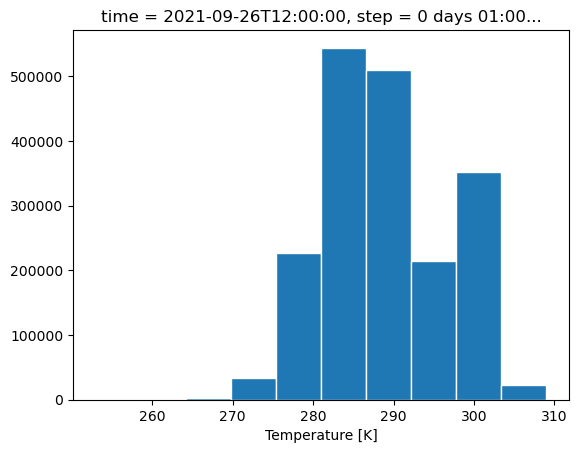

In [49]:
ds.t.plot.hist(edgecolor="white");

In [50]:
ds.t.attrs

{'GRIB_paramId': 130,
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': 1905141,
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'lambert',
 'GRIB_DxInMetres': 3000.0,
 'GRIB_DyInMetres': 3000.0,
 'GRIB_LaDInDegrees': 38.5,
 'GRIB_Latin1InDegrees': 38.5,
 'GRIB_Latin2InDegrees': 38.5,
 'GRIB_LoVInDegrees': 262.5,
 'GRIB_NV': 0,
 'GRIB_Nx': 1799,
 'GRIB_Ny': 1059,
 'GRIB_cfName': 'air_temperature',
 'GRIB_cfVarName': 't',
 'GRIB_gridDefinitionDescription': 'Lambert Conformal can be secant or tangent, conical or bipolar',
 'GRIB_iScansNegatively': 0,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': 21.138123,
 'GRIB_latitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_longitudeOfFirstGridPointInDegrees': 237.280472,
 'GRIB_longitudeOfSouthernPoleInDegrees': 0.0,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': 'Temperature',
 'GRIB_shortName': 't',
 'GRIB_units': 'K',
 'long_na

In [78]:
ds.data_vars

Data variables:
    t        (y, x) float32 298.1 298.1 298.1 298.2 ... 285.9 286.0 286.1 286.1

In [82]:
ds.t.to_pandas()

x,0,1,2,3,4,5,6,7,8,9,...,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798
y,,,,,,,,,,,,,,,,,,,,,
0,298.128784,298.128784,298.128784,298.191284,298.191284,298.191284,298.191284,298.191284,298.191284,298.191284,...,302.753784,302.753784,302.753784,302.753784,302.753784,302.691284,302.691284,302.691284,302.691284,302.691284
1,298.066284,298.128784,298.128784,298.128784,298.191284,298.191284,298.191284,298.191284,298.191284,298.191284,...,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.691284,302.691284,302.691284,302.691284
2,298.066284,298.066284,298.128784,298.128784,298.128784,298.128784,298.191284,298.191284,298.191284,298.191284,...,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.691284,302.691284
3,298.003784,298.066284,298.066284,298.128784,298.128784,298.128784,298.128784,298.128784,298.128784,298.191284,...,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784
4,298.003784,298.003784,298.066284,298.128784,298.128784,298.128784,298.128784,298.128784,298.128784,298.128784,...,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784,302.753784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,...,285.753784,285.753784,285.816284,285.878784,285.941284,285.941284,286.003784,286.066284,286.128784,286.128784
1055,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,...,285.753784,285.753784,285.816284,285.878784,285.941284,285.941284,286.003784,286.003784,286.066284,286.128784
1056,288.691284,288.691284,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,288.753784,...,285.691284,285.753784,285.816284,285.878784,285.878784,285.941284,285.941284,286.003784,286.066284,286.128784


In [47]:
ds.attrs

{'GRIB_edition': 2,
 'GRIB_centre': 'kwbc',
 'GRIB_centreDescription': 'US National Weather Service - NCEP',
 'GRIB_subCentre': 0,
 'Conventions': 'CF-1.7',
 'institution': 'US National Weather Service - NCEP',
 'history': '2023-02-07T15:43 GRIB to CDM+CF via cfgrib-0.9.10.3/ecCodes-2.28.0 with {"source": "..\\\\..\\\\..\\\\..\\\\..\\\\AppData\\\\Local\\\\Temp\\\\delete_later_2pzub2l2", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}'}

In [64]:
ds.rio.grid_mapping

'spatial_ref'

In [41]:
(minx, miny, maxx, maxy) = sample_bbox

In [42]:
sample_bbox

[-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755]

In [52]:
ds.rio.write_grid_mapping()

<xarray.Dataset>
Dimensions:     (y: 1059, x: 1799)
Coordinates:
    time        datetime64[ns] 2021-09-26T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2021-09-26T13:00:00
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 298.1 298.1 298.1 298.2 ... 286.0 286.1 286.1
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-02-07T15:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [58]:
ds.latitude

<xarray.DataArray 'latitude' (y: 1059, x: 1799)>
[1905141 values with dtype=float64]
Coordinates:
    time        datetime64[ns] 2021-09-26T12:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2021-09-26T13:00:00
Dimensions without coordinates: y, x
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude

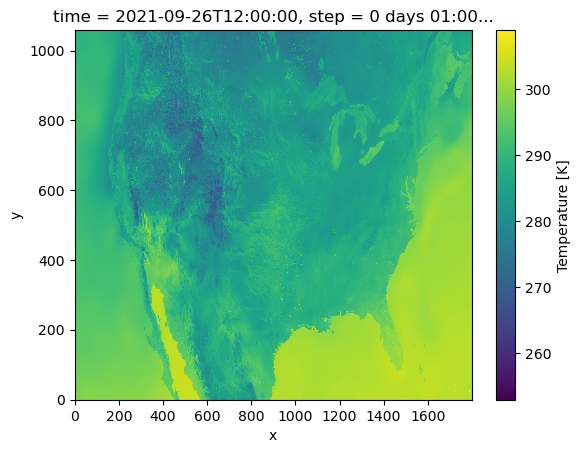

In [55]:
ds.t.plot()

In [53]:
ds.rio.clip_box(
        minx=minx-1,
        miny=miny-1,
        maxx=maxx+1,
        maxy=maxy+1,
        crs="EPSG:4326",
    )

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: t

# This is me doing crazy stuff

In [90]:
rds = rioxarray.open_rasterio(file.name)

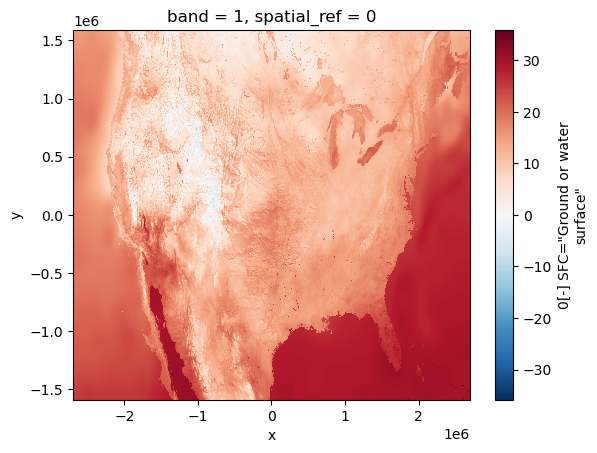

In [91]:
rds.plot()

In [92]:
rds.to_numpy().shape

(1, 1059, 1799)

In [93]:
rds

<xarray.DataArray (band: 1, y: 1059, x: 1799)>
array([[[15.541284, 15.541284, ..., 12.916284, 12.978784],
        [15.541284, 15.541284, ..., 12.916284, 12.978784],
        ...,
        [24.916284, 24.978784, ..., 29.541284, 29.541284],
        [24.978784, 24.978784, ..., 29.541284, 29.541284]]])
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0
Attributes: (12/15)
    GRIB_COMMENT:                        Temperature [C]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        TMP
    GRIB_FORECAST_SECONDS:               3600
    GRIB_IDS:                            CENTER=7(US-NCEP) SUBCENTER=0 MASTER...
    GRIB_PDS_PDTN:                       0
    ...                                  ...
    GRIB_SHORT_NAME:                     0-SFC
    GRIB_UNIT:                           [C]
    GRIB_VALID_TIME:                     1632661200
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           0[-] SFC="Ground or water surface"

In [94]:
rds.rio.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",38.5],PARAMETER["central_meridian",-97.5],PARAMETER["standard_parallel_1",38.5],PARAMETER["standard_parallel_2",38.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [95]:
rds.rio.estimate_utm_crs()

CRS.from_epsg(32614)

In [36]:
test_rds = rds.rio.write_crs('epsg:32614')

In [41]:
test_rds = test_rds.rename(x='lon', y='lat')

In [42]:
test_rds.rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat"
#     inplace=True,
)

<xarray.DataArray (band: 1, lat: 1059, lon: 1799)>
array([[[288.691284, 288.691284, ..., 286.066284, 286.128784],
        [288.691284, 288.691284, ..., 286.066284, 286.128784],
        ...,
        [298.066284, 298.128784, ..., 302.691284, 302.691284],
        [298.128784, 298.128784, ..., 302.691284, 302.691284]]])
Coordinates:
  * band         (band) int32 1
  * lon          (lon) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * lat          (lat) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0
Attributes: (12/15)
    GRIB_COMMENT:                        (prodType 0, cat 0, subcat 0) [-]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        unknown
    GRIB_FORECAST_SECONDS:               3600
    GRIB_IDS:                            CENTER=7 SUBCENTER=0 MASTER_TABLE=2 ...
    GRIB_PDS_PDTN:                       0
    ...                                  ...
    GRIB_SHORT_NAME:                     0-RESERVED
    GRIB_UNIT:                           [-]
    GRIB_VALID_TIME:                     1632661200
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           0[-] RESERVED="Reserved"

In [47]:
test_rds.lon

<xarray.DataArray 'lon' (lon: 1799)>
array([-2697520.142522, -2694520.142522, -2691520.142522, ...,  2690479.857478,
        2693479.857478,  2696479.857478])
Coordinates:
  * lon          (lon) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
    spatial_ref  int32 0

In [37]:
test_rds.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int32 0
Attributes: (12/18)
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 14N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    ...                                ...
    longitude_of_central_meridian:     -99.0
    false_easting:                     500000.0
    false_northing:                    0.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 14N",GEOGCS[...
    GeoTransform:                      -2699020.14252193 3000.0 0.0 1588193.8...

In [48]:
test_rds.x

<xarray.DataArray (band: 1, y: 1059, x: 1799)>
[1905141 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0
Attributes: (12/15)
    GRIB_COMMENT:                        (prodType 0, cat 0, subcat 0) [-]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        unknown
    GRIB_FORECAST_SECONDS:               3600
    GRIB_IDS:                            CENTER=7 SUBCENTER=0 MASTER_TABLE=2 ...
    GRIB_PDS_PDTN:                       0
    ...                                  ...
    GRIB_SHORT_NAME:                     0-RESERVED
    GRIB_UNIT:                           [-]
    GRIB_VALID_TIME:                     1632661200
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           0[-] RESERVED="Reserved"

In [89]:
test_rds.plot()

NameError: name 'test_rds' is not defined

In [41]:
(minx, miny, maxx, maxy) = sample_bbox

In [63]:
sample_bbox

[-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755]

In [62]:
test_rds.rio.crs

CRS.from_epsg(4326)

In [64]:
test_rds.rio.clip_box(
        minx=minx-1,
        miny=miny-1,
        maxx=maxx+1,
        maxy=maxy+1,
        crs="EPSG:4326",
    )

OneDimensionalRaster: At least one of the clipped raster x,y coordinates has only one point.

In [77]:
rds2 = (
    rioxarray.open_rasterio(file.name).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
#         crs="EPSG:4326",
    )
    )

OneDimensionalRaster: At least one of the clipped raster x,y coordinates has only one point.

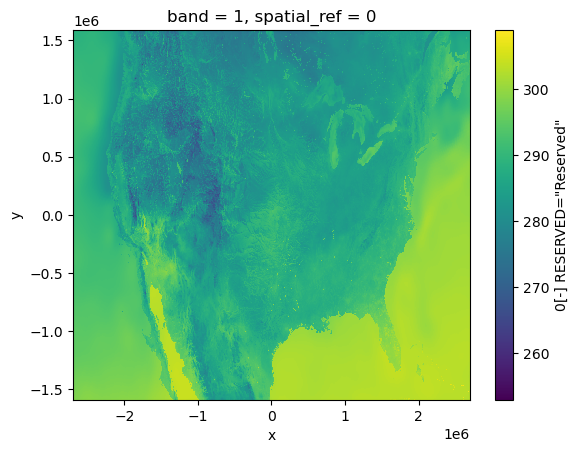

In [73]:
rds.plot()

In [53]:
big_pull.rio.estimate_utm_crs()

CRS.from_epsg(32614)

Can I pull in the whole grib2?

In [51]:
big_pull = rioxarray.open_rasterio(url, parse_coordinates=True)

In [57]:
big_pull_changed = big_pull.rio.write_crs(32614)

In [58]:
big_pull_changed.rio.crs

CRS.from_epsg(32614)

In [60]:
big_pull_changed.coords

Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 ... 702 703 704 705 706 707 708
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0

In [70]:
big_pull_changed.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.DataArray (band: 708, y: 1059, x: 1799)>
[1348839828 values with dtype=float64]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 ... 702 703 704 705 706 707 708
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0
Attributes: (12/15)
    GRIB_COMMENT:                        (prodType 0, cat 3, subcat 5) [-]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        unknown
    GRIB_FORECAST_SECONDS:               3600
    GRIB_IDS:                            CENTER=7 SUBCENTER=0 MASTER_TABLE=2 ...
    GRIB_PDS_PDTN:                       0
    ...                                  ...
    GRIB_SHORT_NAME:                     5000-RESERVED
    GRIB_UNIT:                           [-]
    GRIB_VALID_TIME:                     1632661200
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           ('HGT:50 mb:1 hour fcst', 'TMP:50 mb...

In [ ]:
transform = rio.

In [ ]:
big_pull_changed.rio.wr

This stuff can likely be deleted

In [32]:
import xarray as xr

In [21]:
# Constants for creating the full URL
blob_container = "https://noaahrrr.blob.core.windows.net/hrrr"
sector = "conus"
yesterday = date.today() - timedelta(days=1)
cycle = 12          # noon
forecast_hour = 1   # offset from cycle time
product = "wrfsfcf" # 2D surface levels

# Put it all together
file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"{blob_container}/hrrr.{yesterday:%Y%m%d}/{sector}/{file_path}"

print(url)

https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20230206/conus/hrrr.t12z.wrfsfcf01.grib2


In [22]:
# Fetch the idx file by appending the .idx file extension to our already formatted URL
r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

# Take a peek at the content of the index
print(*idx[0:10], sep="\n")

1:0:d=2023020612:REFC:entire atmosphere:1 hour fcst:
2:294585:d=2023020612:RETOP:cloud top:1 hour fcst:
3:422792:d=2023020612:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:1 hour fcst:
4:795117:d=2023020612:VIL:entire atmosphere:1 hour fcst:
5:1003224:d=2023020612:VIS:surface:1 hour fcst:
6:2462896:d=2023020612:REFD:1000 m above ground:1 hour fcst:
7:2623507:d=2023020612:REFD:4000 m above ground:1 hour fcst:
8:2733189:d=2023020612:REFD:263 K level:1 hour fcst:
9:2883435:d=2023020612:GUST:surface:1 hour fcst:
10:4219834:d=2023020612:UGRD:250 mb:1 hour fcst:


In [24]:
idx

['1:0:d=2023020612:REFC:entire atmosphere:1 hour fcst:',
 '2:294585:d=2023020612:RETOP:cloud top:1 hour fcst:',
 '3:422792:d=2023020612:var discipline=0 center=7 local_table=1 parmcat=16 parm=201:entire atmosphere:1 hour fcst:',
 '4:795117:d=2023020612:VIL:entire atmosphere:1 hour fcst:',
 '5:1003224:d=2023020612:VIS:surface:1 hour fcst:',
 '6:2462896:d=2023020612:REFD:1000 m above ground:1 hour fcst:',
 '7:2623507:d=2023020612:REFD:4000 m above ground:1 hour fcst:',
 '8:2733189:d=2023020612:REFD:263 K level:1 hour fcst:',
 '9:2883435:d=2023020612:GUST:surface:1 hour fcst:',
 '10:4219834:d=2023020612:UGRD:250 mb:1 hour fcst:',
 '11:5005056:d=2023020612:VGRD:250 mb:1 hour fcst:',
 '12:5762941:d=2023020612:UGRD:300 mb:1 hour fcst:',
 '13:6536869:d=2023020612:VGRD:300 mb:1 hour fcst:',
 '14:7286060:d=2023020612:HGT:500 mb:1 hour fcst:',
 '15:8014662:d=2023020612:TMP:500 mb:1 hour fcst:',
 '16:8561882:d=2023020612:DPT:500 mb:1 hour fcst:',
 '17:9461884:d=2023020612:UGRD:500 mb:1 hour fcst:

In [25]:
# You can see it has a 1-indexed base line number, staring byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
print("Surface temp line:", sfc_temp_idx)

# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

Surface temp line: ['64', '40941361', 'd=2023020612', 'TMP', 'surface', '1 hour fcst', '']
Byte range: 40941361-42355521


In [26]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

In [30]:
file.name

'C:\\Users\\nacnu\\AppData\\Local\\Temp\\tmp_sovhowcx'

In [ ]:
rioxarray.open_rasterio()

In [33]:
ds = xr.open_dataset(file.name, engine='cfgrib', 
                     backend_kwargs={'indexpath':''})

ValueError: unrecognized engine cfgrib must be one of: ['scipy', 'rasterio', 'store']

## Trying from aws

In [13]:
sector = "conus"
cycle = 12  # noon
forecast_hour = 1  # offset from cycle time
product = "wrfprsf"  # 3D Pressure Levels
sample_date = "20190826"  # August 8 2019

file_path = f"hrrr.t{cycle:02}z.{product}{forecast_hour:02}.grib2"
url = f"https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{sample_date}/{sector}/{file_path}"
print(f"Full URL: {url}")

r = requests.get(f"{url}.idx")
idx = r.text.splitlines()

Full URL: https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20190826/conus/hrrr.t12z.wrfprsf01.grib2


In [14]:
idx

['1:0:d=2019082612:HGT:50 mb:1 hour fcst:',
 '2:702620:d=2019082612:TMP:50 mb:1 hour fcst:',
 '3:1252887:d=2019082612:RH:50 mb:1 hour fcst:',
 '4:1384611:d=2019082612:DPT:50 mb:1 hour fcst:',
 '5:1384799:d=2019082612:SPFH:50 mb:1 hour fcst:',
 '6:2124174:d=2019082612:VVEL:50 mb:1 hour fcst:',
 '7:2405768:d=2019082612:UGRD:50 mb:1 hour fcst:',
 '8:2968791:d=2019082612:VGRD:50 mb:1 hour fcst:',
 '9:3530253:d=2019082612:ABSV:50 mb:1 hour fcst:',
 '10:4095921:d=2019082612:CLMR:50 mb:1 hour fcst:',
 '11:4096109:d=2019082612:CIMIXR:50 mb:1 hour fcst:',
 '12:4096297:d=2019082612:RWMR:50 mb:1 hour fcst:',
 '13:4096485:d=2019082612:SNMR:50 mb:1 hour fcst:',
 '14:4100934:d=2019082612:GRLE:50 mb:1 hour fcst:',
 '15:4101179:d=2019082612:HGT:75 mb:1 hour fcst:',
 '16:4819410:d=2019082612:TMP:75 mb:1 hour fcst:',
 '17:5383148:d=2019082612:RH:75 mb:1 hour fcst:',
 '18:5791591:d=2019082612:DPT:75 mb:1 hour fcst:',
 '19:5793470:d=2019082612:SPFH:75 mb:1 hour fcst:',
 '20:6401334:d=2019082612:VVEL:75 mb

In [15]:
# You can see it has a 1-indexed base line number, staring byte position, date, variable, atmosphere level,
# and forecast description. The lines are colon-delimited. 

# Let's grab surface temperature `TMP:surface`.
sfc_temp_idx = [l for l in idx if ":TMP:surface" in l][0].split(":")
print("Surface temp line:", sfc_temp_idx)

# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

Surface temp line: ['609', '309324225', 'd=2019082612', 'TMP', 'surface', '1 hour fcst', '']
Byte range: 309324225-310694021


In [20]:
# trying to find other things that might help...
any_surface_data = [l for l in idx if ":surface" in l]
# print("Surface precipitation line:", sfc_precipitation_idx)

In [21]:
any_surface_data

['581:290863590:d=2019082612:VIS:surface:1 hour fcst:',
 '585:292812270:d=2019082612:GUST:surface:1 hour fcst:',
 '607:305502590:d=2019082612:PRES:surface:1 hour fcst:',
 '608:307089448:d=2019082612:HGT:surface:1 hour fcst:',
 '609:309324225:d=2019082612:TMP:surface:1 hour fcst:',
 '610:310694021:d=2019082612:ASNOW:surface:0-1 hour acc fcst:',
 '612:312152696:d=2019082612:CNWAT:surface:1 hour fcst:',
 '613:312266514:d=2019082612:WEASD:surface:1 hour fcst:',
 '614:312267655:d=2019082612:SNOWC:surface:1 hour fcst:',
 '615:312268540:d=2019082612:SNOD:surface:1 hour fcst:',
 '626:324819288:d=2019082612:CPOFP:surface:1 hour fcst:',
 '627:324982832:d=2019082612:PRATE:surface:1 hour fcst:',
 '628:325075554:d=2019082612:APCP:surface:0-1 hour acc fcst:',
 '629:325372665:d=2019082612:WEASD:surface:0-1 hour acc fcst:',
 '630:325376515:d=2019082612:FROZR:surface:0-1 hour acc fcst:',
 '631:325377399:d=2019082612:FRZR:surface:0-1 hour acc fcst:',
 '632:325378414:d=2019082612:SSRUN:surface:0-1 hour a

- I want PRES (its surface pressure in Pa)
- I want TMP (surface temp in K)
- maybe SNOD (snow depth in m)
- I want GUST (wind gust in m/s)
- I want PRATE (precipitation rate in kg/m^2s)

In [22]:
sfc_temp_idx = [l for l in any_surface_data if ":TMP:surface" in l][0].split(":")


In [23]:
sfc_temp_idx

['609', '309324225', 'd=2019082612', 'TMP', 'surface', '1 hour fcst', '']

In [24]:
# Pluck the byte offset from this line, plus the beginning offset of the next line
line_num = int(sfc_temp_idx[0])
range_start = sfc_temp_idx[1]

# The line number values are 1-indexed, so we don't need to increment it to get the next list index,
# but check we're not already reading the last line
next_line = idx[line_num].split(':') if line_num < len(idx) else None

# Pluck the start of the next byte offset, or nothing if we were on the last line
range_end = next_line[1] if next_line else None

print(f"Byte range: {range_start}-{range_end}")

Byte range: 309324225-310694021


In [25]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="delete_later_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)

In [26]:
rds = rioxarray.open_rasterio(file.name)

In [27]:
rds

<xarray.DataArray (band: 1, y: 1059, x: 1799)>
[1905141 values with dtype=float64]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y            (y) float64 1.587e+06 1.584e+06 ... -1.584e+06 -1.587e+06
    spatial_ref  int32 0
Attributes: (12/15)
    GRIB_COMMENT:                        (prodType 0, cat 0, subcat 0) [-]
    GRIB_DISCIPLINE:                     0(Meteorological)
    GRIB_ELEMENT:                        unknown
    GRIB_FORECAST_SECONDS:               3600
    GRIB_IDS:                            CENTER=7 SUBCENTER=0 MASTER_TABLE=2 ...
    GRIB_PDS_PDTN:                       0
    ...                                  ...
    GRIB_SHORT_NAME:                     0-RESERVED
    GRIB_UNIT:                           [-]
    GRIB_VALID_TIME:                     1566824400
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           0[-] RESERVED="Reserved"

In [28]:
rds.t.plot.hist(edgecolor="white")
plt.show()

AttributeError: 'DataArray' object has no attribute 't'

In [ ]:
import tempfile
file = tempfile.NamedTemporaryFile(prefix="tmp_", delete=False)

headers = {"Range": f"bytes={range_start}-{range_end}"}
resp = requests.get(url, headers=headers, stream=True)

with file as f:
    f.write(resp.content)